In [11]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize, StandardScaler
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import CategoricalNB, GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, \
average_precision_score, roc_auc_score, plot_precision_recall_curve, plot_roc_curve, plot_confusion_matrix 
from sklearn.exceptions import ConvergenceWarning
from sklearn.decomposition import PCA
from xgboost import XGBClassifier, XGBRFClassifier, plot_importance

from imblearn.over_sampling import SMOTENC

import matplotlib.pyplot as plt

import warnings

from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer

from IPython.display import clear_output


import pickle

import os
import sys
module_path = os.path.abspath(os.path.join(os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)
from src.functions import test_model, get_timeseries_table, add_model,\
add_hypersearch

from seaborn import heatmap

warnings.filterwarnings("ignore", category=ConvergenceWarning)

In [7]:
def return_score(optim_result):
    """
    callback for a hyperparameter search.  Displays current best score and 
    best parameters.  To be added to the fit method, callback argument.
    """
    score = opt.best_score_
    params = pd.DataFrame(opt.best_params_, index=[0])
    clear_output()
    print('Best Score So Far: ', score)
    print('Using Parameters: ')
    display(params)

## Data

We start off by loading our data.  We only load data from the first half of the course because we want to identify students who may need intervention while there is still time for intervention to be effective.  The courses are 270 days long, so we load the first 135 days worth of data to use to make our predictions.  This date can be pushed forward by changing the `prediction_window` variable.  Later predictions are more accurate, earlier predictions can lead to more successful interventions.  It should be noted that these courses are self-paced, but assessments do have due dates.

This data, after preprocessing the given trace data, contains several columns for each day of the course, up to the date we choose to make our prediction.  These metrics are:

1. Number of activities completed on each day.  Activities vary from web links to quizzes.

2. Number of clicks each day.

3. A polynomial feature, clicks * activities, to capture the fact that different activities require different numbers of clicks.

The last rows are not timeseries, but have to do with assessments and the course module that the data comes from.

4. Assessment scores for each completed assessment.  I found in previous models that assessment scores are highly predictive of course outcomes. 

5. The timing of the assessment completion.  In previous exploration, there was a correlation between when students completed assessments and course outcomes.  Completing more assessments earlier in the course correlated to a greater chance of passing the course.

6. One-hot-encoding of the course module code.  The course modules vary greatly in their pass/fail rates, average clicks and activities, and assessment scores.  Which course a student is taking is highly correlated to whether they will pass it. As you will see in the final model feature importances at the end of this notebook.

## Class Balance

The pass/fail ratio is about 3 to 1.  This is not such a terrible class balance, but my models consistently over-predict students to pass, and using the synthetic data oversampling technique called SMOTE helps to prevent the models from learning to just default to pass to improve their accuracy.

In [8]:
prediction_window = 135

df = get_timeseries_table(prediction_window=prediction_window,
                         binary_labels=True, one_hot_modules=True)

df.shape
df.final_result.value_counts()

0    15364
1     7511
Name: final_result, dtype: int64

In [27]:
X = df.drop(columns=['final_result'])
y = df['final_result']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=111)
X_t, X_val, y_t, y_val = train_test_split(X_train, y_train, random_state=111)

all_features = 'SMOTED activites, clicks, activities*clicks, assessments, modules'

categoricals = [502, 501, 500, 499, 498, 497, 496]
smotenc = SMOTENC(categoricals, random_state=111)
X_train, y_train = smotenc.fit_resample(X_train, y_train)
X_t, y_t = smotenc.fit_resample(X_t, y_t)

X_t_normal = normalize(X_t)
X_val_normal = normalize(X_val)
X_train_normal = normalize(X_train)
X_test_normal = normalize(X_test)


pca = PCA(n_components = 300)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)
X_t_pca = pca.fit_transform(X_t)
X_val_pca = pca.fit_transform(X_val)

<AxesSubplot:>

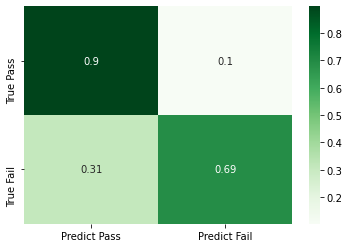

In [15]:
model = pickle.load(open('time_series_xgb_best_smote.pkl', 'rb'))
model.fit(X_train, y_train)

yhat = model.predict(X_test)

confusion  = confusion_matrix(y_test, yhat, normalize='true')
heatmap(confusion, annot=True, cmap='Greens',
       xticklabels = ['Predict Pass', 'Predict Fail'],
       yticklabels = ['True Pass', 'True Fail'])

<AxesSubplot:>

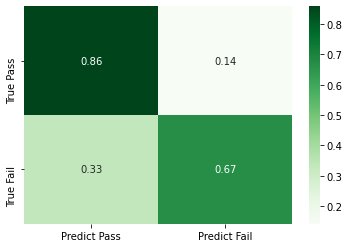

In [16]:
model = pickle.load(open('time_series_xgb_best_smote.pkl', 'rb'))
model.fit(X_train_pca, y_train)

yhat = model.predict(X_test_pca)

confusion  = confusion_matrix(y_test, yhat, normalize='true')
heatmap(confusion, annot=True, cmap='Greens',
       xticklabels = ['Predict Pass', 'Predict Fail'],
       yticklabels = ['True Pass', 'True Fail'])

# Choosing from available models

We will try several out of the box models on this data to see, in broad terms, which model might be most successful.  Later we will choose the most accurate ones and tune their parameters to make a final determination on which one to use.

### Metrics

I chose ROC AUC as my target metric because we have an opportunity to tune the probability thresholds on the final model to find the right balance between recall and precision in the final classifier.  I want the model that performs best over all thresholds, so future stakeholders can make choices about how to balance unnecessary interventions and students needing intervention that don't get it.

In [5]:
models = [LogisticRegression(random_state=111, solver='liblinear'),
         DecisionTreeClassifier(random_state=111),
         RandomForestClassifier(random_state=111),
         KNeighborsClassifier(),
         SVC(random_state=111, probability=True),
         SGDClassifier(loss='log', random_state=111),
         AdaBoostClassifier(random_state=111),
         XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=111),      
         ]

for model in models:
    model.fit(X_t, y_t)
    add_model(model, X_t, y_t, X_val, y_val, 
              preprocessing=None, 
              features = all_features)


## Does normalizing the data help?

We need to normalize data to try Naive Bayes models anyway, so I decided to try them all with normally distritbuted data, just in case it helps.  It turns out that Bayesian models are not the right model for this problem, and normalizing the data didn't help the others much.  But, it was worth a try.

In [6]:
models = [LogisticRegression(random_state=111, solver='liblinear'),
         DecisionTreeClassifier(random_state=111),
         RandomForestClassifier(random_state=111),
         CategoricalNB(),
         GaussianNB(),
         KNeighborsClassifier(),
         SVC(random_state=111, probability=True),
         AdaBoostClassifier(random_state=111),
         XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=111)      
         ]

for model in models:
    model.fit(X_t_normal, y_t)
    add_model(model, X_t_normal, y_t, X_val_normal, y_val, 
              features = all_features,
              preprocessing='normalized')


In [7]:
pd.read_csv('hyperparameter_table.csv').dropna(axis=0, subset=['val_accuracy'])

model  val_roc_auc  train_roc_auc  val_accuracy  \
0            XGBClassifier     0.861970       0.998315      0.815342   
1   RandomForestClassifier     0.856052       1.000000      0.816740   
2       AdaBoostClassifier     0.854784       0.922121      0.795990   
3            XGBClassifier     0.835061       0.997274      0.792026   
4   RandomForestClassifier     0.822697       1.000000      0.794824   
5       AdaBoostClassifier     0.805564       0.870255      0.752623   
6                      SVC     0.780075       0.884588      0.727209   
7       LogisticRegression     0.771498       0.814467      0.706925   
8                      SVC     0.763789       0.959379      0.729074   
9       LogisticRegression     0.745960       0.798525      0.709256   
10  DecisionTreeClassifier     0.723335       1.000000      0.742364   
11              GaussianNB     0.716877       0.765642      0.685474   
12  DecisionTreeClassifier     0.688599       1.000000      0.709956   
13           SGDClassifier     0.631460       0.669943      0.643740   
14    KNeighborsClassifier     0.626627       0.913115      0.511541   
15    KNeighborsClassifier     0.609028       0.907723      0.523665   
16           CategoricalNB     0.500000       0.500000      0.665190   

    train_accuracy  val_f1_score  train_f1_score  \
0         0.978650      0.701807        0.978583   
1         1.000000      0.687102        1.000000   
2         0.844201      0.698795        0.843206   
3         0.974033      0.672059        0.973898   
4         1.000000      0.650516        1.000000   
5         0.789671      0.647157        0.786154   
6         0.804674      0.621849        0.809799   
7         0.734737      0.612157        0.738554   
8         0.892902      0.597924        0.893272   
9         0.717369      0.585301        0.703726   
10        1.000000      0.633742        1.000000   
11        0.720716      0.579095        0.719583   
12        1.000000      0.590250        1.000000   
13        0.669186      0.528395        0.668785   
14        0.735776      0.517837        0.783058   
15        0.756434      0.506164        0.795027   
16        0.500000      0.000000        0.000000   

                                             features preprocessing    C  ...  \
0   SMOTED activites, clicks, activities*clicks, a...           NaN  NaN  ...   
1   SMOTED activites, clicks, activities*clicks, a...           NaN  NaN  ...   
2   SMOTED activites, clicks, activities*clicks, a...           NaN  NaN  ...   
3   SMOTED activites, clicks, activities*clicks, a...    normalized  NaN  ...   
4   SMOTED activites, clicks, activities*clicks, a...    normalized  NaN  ...   
5   SMOTED activites, clicks, activities*clicks, a...    normalized  NaN  ...   
6   SMOTED activites, clicks, activities*clicks, a...           NaN  1.0  ...   
7   SMOTED activites, clicks, activities*clicks, a...    normalized  1.0  ...   
8   SMOTED activites, clicks, activities*clicks, a...    normalized  1.0  ...   
9   SMOTED activites, clicks, activities*clicks, a...           NaN  1.0  ...   
10  SMOTED activites, clicks, activities*clicks, a...           NaN  NaN  ...   
11  SMOTED activites, clicks, activities*clicks, a...    normalized  NaN  ...   
12  SMOTED activites, clicks, activities*clicks, a...    normalized  NaN  ...   
13  SMOTED activites, clicks, activities*clicks, a...           NaN  NaN  ...   
14  SMOTED activites, clicks, activities*clicks, a...           NaN  NaN  ...   
15  SMOTED activites, clicks, activities*clicks, a...    normalized  NaN  ...   
16  SMOTED activites, clicks, activities*clicks, a...    normalized  NaN  ...   

    scale_pos_weight subsample tree_method  validate_parameters  verbosity  \
0                1.0       1.0       exact                  1.0        NaN   
1                NaN       NaN         NaN                  NaN        NaN   
2                NaN       NaN         NaN                  NaN        NaN   
3               

## Model shortlist

It turns out the tree based models are performing best on this data.  We will take the XGBoost, Random Forest, and Decision Tree models forward and see if we can tune the hyperparameters to achieve a better ROC AUC score.

In [10]:
xgb = XGBClassifier(use_label_encoder=False, seed=111, eval_metric='logloss')

xgb_search_space = {'objective': Categorical(['binary:logistic',
                                              'binary:hinge']),
                    'eval_metric': Categorical(['logloss','error']),
                   'learning_rate': Real(0.05, .3, 'log-uniform'),
                   'min_child_weight': Integer(1,10, 'uniform'),
                   'max_depth': Integer(20,60, 'normal'),
                   'subsample': Real(0.3, 1, 'normal'),
                   'colsample_bytree': Real(.3, 1.0, 'normal'),
                   'scale_pos_weight': Real(.5, 2.0, 'uniform')}

opt = BayesSearchCV(xgb, search_spaces=xgb_search_space, 
                    n_iter=50, cv=2,
                    n_jobs=4,
                    pre_dispatch = 8,
                    random_state=111,
                    return_train_score=True,
                    scoring='roc_auc')

opt.fit(X_t, y_t, callback=[return_score])

XGBmodel = opt.best_estimator_

add_hypersearch(opt)

add_model(XGBmodel, X_t, y_t, X_val, y_val, 
          features = all_features,
          preprocessing=None)

Best Score So Far:  0.9351039335222676
Using Parameters:     colsample_bytree eval_metric  learning_rate  max_depth  min_child_weight  \
0               0.3       error       0.099136         20                 1   

         objective  scale_pos_weight  subsample  
0  binary:logistic               2.0        1.0  


In [ ]:
rf = RandomForestClassifier(random_state=111)

rf_search_space = {'n_estimators': Integer(50, 500, 'normal'),
                   'max_depth': Integer(5, 50, 'normal'),
                   'max_features': Categorical(['sqrt','log2',None]),
                   'class_weight': Categorical(['balanced','balanced_subsample',None]),
                   'max_samples': Real(.1, .99, 'uniform')
                   }

opt = BayesSearchCV(rf, search_spaces=rf_search_space, 
                    n_iter=50, cv=2,
                    n_jobs=4,
                    pre_dispatch = 8,
                    random_state=111,
                    return_train_score=True,
                    scoring='roc_auc')

opt.fit(X_t, y_t, callback=[return_score])

RFclf = opt.best_estimator_

add_hypersearch(opt)

add_model(RFclf, X_t, y_t, X_val, y_val, 
          features=all_features, 
          preprocessing=None)

Best Score So Far:  0.9338657842633965
Using Parameters:           class_weight  max_depth max_features  max_samples  n_estimators
0  balanced_subsample         48         sqrt         0.99           404


In [ ]:
DT = DecisionTreeClassifier(random_state=111)

DT_search_space = {'criterion': Categorical(['gini','entropy']),
                   'splitter': Categorical(['best','random']),
                    'max_depth': Integer(3,10, 'uniform'),
                   'max_features': Categorical(['sqrt','log2', None]),
                   'class_weight': Categorical(['balanced',None]),
                   }

opt = BayesSearchCV(DT, search_spaces=DT_search_space, 
                    n_iter=50, cv=2,
                    n_jobs=4,
                    pre_dispatch = 8,
                    random_state=111,
                    scoring='roc_auc',
                    return_train_score=True)

opt.fit(X_t, y_t, callback=[return_score])

DTclf = opt.best_estimator_

add_hypersearch(opt)

add_model(DTclf, X_t, y_t, X_val, y_val, 
          features=all_features, 
          preprocessing=None)

In [ ]:
table = pd.read_csv('hyperparameter_table.csv').dropna(axis=0, subset=['val_accuracy'])

# Final model:  XGBoost

XGBoost, a tree based boosting ensemble model, has shown great success in Kaggle competitions, and has been a great model for previous projects.  I'm not surprised it provides the best results here.  Let's explore this model a little more. 

Loading model from storage


<AxesSubplot:>

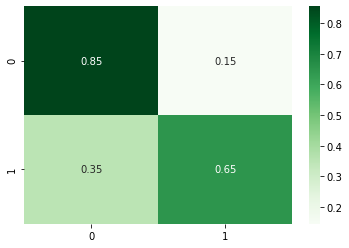

In [30]:
try:
    clf=XGBmodel
    print('Loading model from memory')
except:
    clf=pickle.load(open('time_series_xgb_best_smote.pkl', 'rb'))
    print('Loading model from storage')
    
clf.fit(X_train_pca, y_train)


y_score = clf.predict_proba(X_test_pca)[:,1]

yhat = pd.Series(np.round_(y_score))

confusion  = confusion_matrix(y_test, yhat, normalize='true')
heatmap(confusion, annot=True, cmap='Greens')

## Confusion Matrix

The confusion matrix below is normalized across the true axis.  The top two boxes represent students who will truly pass the course.  The box in the top left is the percentage of passing students that the model accurately labeled as passing, and the to right is the percent of passing students labeled as likely not to pass, to fail or withdraw early.  Similarly the bottom left are students who will not pass, but the model predicts they will, and the bottom right are the percentage of students who will not pass that the model accurately predicts.

We see here that the model still is over predicting student success.  26% of student in need of intervention will not receive it.  However, only 10% of students that model suggests for intervention will not need it.  I think there are just a lot of students who seem like they should pass, but don't.  Sometimes life happens, even to a strong student.

XGBoostError: [17:08:55] C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1183: Check failed: learner_model_param_.num_feature >= p_fmat->Info().num_col_ (300 vs. 503) : Number of columns does not match number of features in booster.

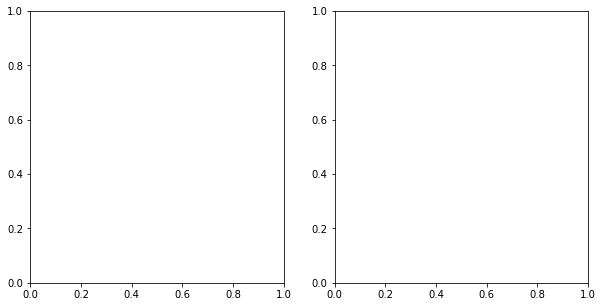

In [31]:
fig, axes = plt.subplots(1,2, figsize=(10,5))
plot_precision_recall_curve(clf, X_test, y_test, ax = axes[0])
axes[0].set_title('Precision-Recall Curve')

plot_roc_curve(clf, X_test, y_test, ax= axes[1])
axes[1].set_title('ROC Curve')
plt.show()

## Tuning the prediction probability threshold

A stakeholder can tune the threshold probability that our model uses to classify a student as likely to pass or likely not to.  I use F1 score because it gives me an idea of both prevision and recall, where accuracy can be confounded by class imbalance in the test set.

It turns out that a probability threshold of 41% gives us the best F1 score. But, you'll notice below that while it is quite accurate at predicting student who will pass, but much less so at predicting who needs interventions.  If interventions were very expensive, such as providing housing, regulary tutoring, childcare subsidies, etc., a stakeholder would want a high precision for the students assigned intervention, as shown below.  However, if interventions are cheap and failure is expensive they would want to adjust the probability threshold to improve the recall for students in danger of failing at the expense of more unneeded interventions for student who would succeed either way.

In [ ]:
thresh_accuracy = pd.DataFrame(columns= ['accuracy', 'f1_score'],
                              index = [x/100 for x in range(60,80)])

thresh_accuracy.index.name = 'Threshold'
for thresh in range(10, 90):
    thresh /= 100
    yhat = pd.Series(y_score).apply(lambda x: 1 if x >= thresh else 0)
    accuracy = accuracy_score(y_test, yhat)
    f1 = f1_score(y_test, yhat)
    roc = roc_auc_score(y_test, y_score)
    pr = average_precision_score(y_test, y_score)
    thresh_accuracy.loc[thresh, 'accuracy'] = accuracy
    thresh_accuracy.loc[thresh, 'f1_score'] = f1

print('ROC_AUC: ', roc)
print('PR_AUC: ', pr)
thresh_accuracy = thresh_accuracy.sort_values(by='f1_score', ascending=False)
thresh_accuracy.head(20)

In [ ]:
best_thresh = thresh_accuracy.index[0]

yhat = yhat.apply(lambda x: 1 if x >= best_thresh else 0)

confusion  = confusion_matrix(y_test, yhat, normalize='true')
heatmap(confusion, annot=True, cmap='Greens',
       xticklabels = ['Predict Pass', 'Predict Fail'],
       yticklabels = ['True Pass', 'True Fail'])

## Feature Importance

The below chart ranks the importance of each feature, according to the XGBoost model, from most important leas important.  It seems that whether or not the student is taking the module coded as `GGG` is a big predictor!  It may be that this is the hardest, or easiest of the modules.  We can explore this more later.  We also see that other modules rank high on the list.  It seems that which course a student is in plays an outsized role in determining success.  This might be worth the university's time to look into.  Are some students in courses they aren't prepared for?  Are some instructors going to easy on students in some courses?

We also see that student scores on the 2nd and 3rd assessments are highly predictive.  I knew from previous work that assessment scores were very predictive of success, but this chart shows that some may be more predictive than others.  The first assessments of a module are not important enough to even show up in the top 20 variables, where as the 2nd and 3rd are both in the top 3.  This is a very interesting result, and could be the focus of future study.

We see that that activities per day is mostly important to the model very early, or very late in course dates we are using for prediction.

In [ ]:
importance = pd.DataFrame(clf.feature_importances_, index=X_test.columns)
importance.sort_values(by=0, ascending=False).head(20)

pickle.dump(clf, open('time_series_xgb_best_smote.pkl','wb'))

# Summary

XGBoost was our most successfuly classifier for recommending students for intervention.  It successfully recommends interventions for 74% of students that need them, while recommending interventions for 10% of students who don't need them.  These numbers could bear improvement, but show proof of concept that student/virtual learning environment interactions can be used to predict student success.

It's also important to keep in mind which course a student is enrolled in.  It should not be surprising that some college courses are harder than others.  That's kind of common sense.

# Future research

Future researchers for this dataset might try correlating the types of activities students engage each day with student success.  Some information on this is available in the raw dataset.

They also might look more closely at why early, but not the first, assessment scores are so important.  It may be that reaching out to students who perform poorly on the 2nd and 3rd assessments would be a quick way to target interventions.  Maybe most students are energized to do well on the first assessment, or that first assessments tend to be easier.  There is room for study here.

In [ ]:
table = pd.read_csv('hyperparameter_table.csv')
table = table[table['model'] == 'XGBClassifier'].dropna(axis=1, how='all')
table.to_csv('XGB_hyperparameter_table.csv')